# Malaria cells image classification in PyTorch
### Using Convolutional Neural Network (CNN)
Dawid Stachowiak & Wiktor Kurek

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from torchvision import transforms, datasets, models
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

Loading both datasets for pre-process images

In [7]:
infected_cells = os.listdir('cell_images/Parasitized/') 
uninfected_cells = os.listdir('cell_images/Uninfected/')

As we can see all images have 3 color channels but in different sizes, so we should resize them to one specific shape to unify model's input. I choose the size 64x64. I resizing all images and labeling them so I can add whole data to Dataframe.

In [5]:
images = []
labels = []
width = 64
height = 64
dim = (width, height)

In [8]:
for x in uninfected_cells:
    try:
        if x.endswith(".png"):
            img = cv2.imread(os.path.join('cell_images/Uninfected/', x))
            img = cv2.resize(img,dim)
            images.append(img)
            labels.append(0)
        else:
            continue
    except Exception as e:
        print(str(e))

In [9]:
for x in infected_cells:
    try:
        if x.endswith(".png"):
            img = cv2.imread(os.path.join('cell_images/Parasitized/', x))
            img = cv2.resize(img,dim)
            images.append(img)
            labels.append(1)
        else:
            continue
    except Exception as e:
        print(str(e))

All data was processed succesfully. Below we can see some samples from our dataset to check correctness (`1` - Parasitized cells, `0` - Uninfected cells). In most cases, we are able to recognize with the naked eye whether the cell is infected with malaria. The data is spread evenly inferring from the historgam. The next step will be to partition the dataset into subsets.

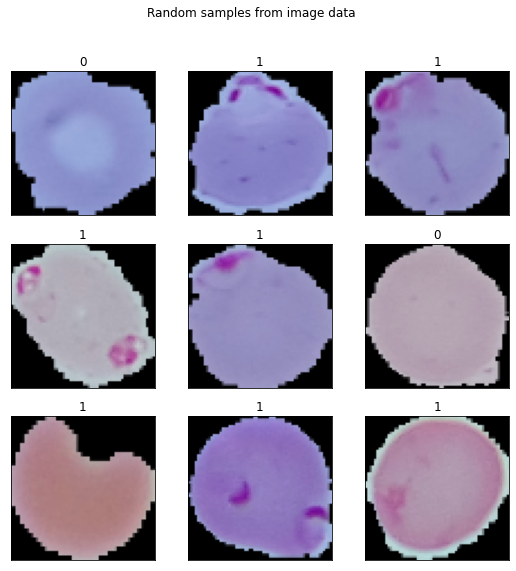

In [10]:
images = np.array(images)
labels = np.array(labels)
plt.figure(1 , figsize = (9 , 9))
plt.suptitle("Random samples from image data")
n = 0
for i in range(9):
    n += 1 
    r = np.random.randint(0 , images.shape[0] , 1)
    plt.subplot(3 , 3 , n)
    plt.subplots_adjust(hspace = 0.2 , wspace = 0.2)
    plt.imshow(images[r[0]])
    plt.title(labels[r[0]])
    plt.xticks([]) , plt.yticks([])
    
plt.show()

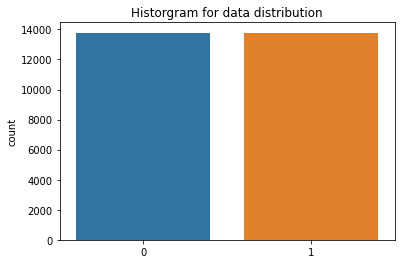

In [7]:
sns.countplot(x = labels)
plt.title("Historgram for data distribution")
plt.show()

Validation part of dataset will be 20% of whole data, test data will be only 10% which is still a lot of cell images.

In [11]:
val_size = int(0.2*len(labels))
test_size = int(0.1*len(labels))
train_size = len(labels) - val_size - test_size
indexes = np.arange(len(labels))
np.random.shuffle(indexes)

val_indexes = indexes[:val_size]
test_indexes = indexes[val_size:val_size+test_size]
train_indexes = indexes[val_size+test_size:]

train_sampler = SubsetRandomSampler(train_indexes)
test_sampler = SubsetRandomSampler(test_indexes)
val_sampler = SubsetRandomSampler(val_indexes)

print("Images in train subset: {}\nImages in validation subset: {}\nImages in test subset: {}".format(
    len(train_indexes), len(val_indexes), len(test_indexes)))

Images in train subset: 19292
Images in validation subset: 5511
Images in test subset: 2755


Now we setting up needed tranformations and connecting dataset with previously created samplers.

In [12]:
transform = transforms.Compose(
    [transforms.Resize(dim),
    transforms.ToTensor(), 
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

img_dir = "cell_images/"
dataset = datasets.ImageFolder(img_dir, transform=transform)

train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=106)
test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=38)
val_loader = DataLoader(dataset, sampler=val_sampler, batch_size=58)

We will try to use pretrainded ResNet50 for malaria problem. ResNet50 is a variant of ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer.

In [15]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(2048, 2, bias=True)

fc_parameters = model.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True
    
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
torch.cuda.is_available()

False

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001 , momentum=0.9)

In [22]:
def train(n_epochs, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        
        for batch_idx, (data, target) in enumerate(train_loader):
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        model.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            loss = loss_fn(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        torch.save(model.state_dict(), save_path)
        ## TODO: save the model if validation loss has decreased
    return model

In [23]:
train(25, model, optimizer, criterion, False, 'malaria_model.pt')

Epoch 1, Batch 1 loss: 0.804548
Epoch 1, Batch 101 loss: 0.411548
Epoch: 1 	Training Loss: 0.368636 	Validation Loss: 0.309803
Epoch 2, Batch 1 loss: 0.334444
Epoch 2, Batch 101 loss: 0.296110
Epoch: 2 	Training Loss: 0.298303 	Validation Loss: 0.283654
Epoch 3, Batch 1 loss: 0.316334
Epoch 3, Batch 101 loss: 0.280303
Epoch: 3 	Training Loss: 0.281547 	Validation Loss: 0.290981
Epoch 4, Batch 1 loss: 0.260337
Epoch 4, Batch 101 loss: 0.265150
Epoch: 4 	Training Loss: 0.268044 	Validation Loss: 0.275959
Epoch 5, Batch 1 loss: 0.239347
Epoch 5, Batch 101 loss: 0.266232
Epoch: 5 	Training Loss: 0.267577 	Validation Loss: 0.271341
Epoch 6, Batch 1 loss: 0.243183
Epoch 6, Batch 101 loss: 0.259220
Epoch: 6 	Training Loss: 0.261100 	Validation Loss: 0.284411
Epoch 7, Batch 1 loss: 0.248840
Epoch 7, Batch 101 loss: 0.264173
Epoch: 7 	Training Loss: 0.257557 	Validation Loss: 0.268430
Epoch 8, Batch 1 loss: 0.276273
Epoch 8, Batch 101 loss: 0.248685
Epoch: 8 	Training Loss: 0.250597 	Validation

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
model.load_state_dict(torch.load('malaria_model.pt'))

<All keys matched successfully>

In [18]:
def test(model, loss_fn, use_cuda):
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(test_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = loss_fn(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
test(model, loss_fn, False)

Test Loss: 0.256550


Test Accuracy: 89% (2471/2755)
